# Modeling

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

np.random.seed(95)
import math

In [2]:
# load data from existing csv
train = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
validate = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)
test = pd.read_csv("./00_project_data/1-3_testing_data.csv", index_col=0)
train.head()

,zipcode,bite
dateofbite,,
2015-01-01,NaN,1
2015-01-01,11220,1
2015-01-01,10026,1
2015-01-01,11221,1
2015-01-01,NaN,1


**Final cleaning**

In [3]:
# covert the index to datetime
train.index = train.index.astype("datetime64")
validate.index = validate.index.astype("datetime64")
test.index = test.index.astype("datetime64")

In [4]:
train = train.resample('D').bite.sum()
validate = validate.resample('D').bite.sum()
test = test.resample('D').bite.sum()
train = pd.DataFrame(train)
validate = pd.DataFrame(validate)
test = pd.DataFrame(test)

train.head()

,bite
dateofbite,
2015-01-01,7
2015-01-02,9
2015-01-03,7
2015-01-04,11
2015-01-05,5


In [5]:
# train = train.resample('W').bite.sum()
# validate = validate.resample('W').bite.sum()
# train = pd.DataFrame(train)
# validate = pd.DataFrame(validate)

# validate.tail()

**Visulize train and validate**

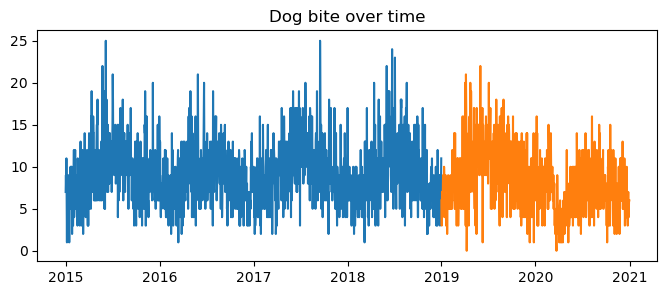

In [6]:
# plt the value value fof bite over time
plt.figure(figsize=(8,3))
plt.plot(train.bite)
plt.plot(validate.bite)
plt.title("Dog bite over time")
plt.show()

**Create an evaluation function**

evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [7]:
# evaluation funtion
def evaluate(target):
    """
    Takes in the target col name and return the root mean square error for
    the validate/test against the predicted values.
    """
    rmse = round(sqrt( # get root mean square error
        mean_squared_error(validate[target], y_pred_df[target])),3) # get mean squared error
    return rmse
    

**Plot evaluation funtion**

In [8]:
# plot predictions vs actual values
def plot_evaluate(target):
    """
    Function will return a plot of the predicted values against the actual values in the data.
    """
    # plt.ioff()
    # plt the value value fof bite over time and the predicted
    plt.figure(figsize=(8,3))
    plt.plot(train.bite, label="Train", linewidth=1)
    plt.plot(validate.bite,label="Validate", linewidth=1)
    plt.plot(y_pred_df[target],label="Prediction", linewidth=1 )
    plt.title("Dog bite over time prediction")
    
    rmse = evaluate(target)
    print(target, f'-- rmse: {round(rmse,2)}')
    plt.legend()

**Evaluation data frame**

In [9]:
# create evaluation dataframe
eval_df = pd.DataFrame(columns=["model", "target", "rmse"])
eval_df

,model,target,rmse


In [10]:
# function to append to the evaluation dataframe
def append_to_eval(model, target):
    """
    Function append the current running model results the historical models.
    """
    rmse = evaluate(target)
    res_dict = pd.DataFrame({"model":[model],
               "target": [target],
               "rmse":[rmse]})
    return pd.concat([eval_df, res_dict])

## Baseline model (Moving Average)

I will use a iterating day lag moving average to forecast.

In [11]:
# looking at 2% of the validation data
lags = math.ceil(validate.shape[0] * .3)

for i in range(1, lags + 1):
    # get the average over a lot of different days
    rolling_quantity = round(train.bite.rolling(i).mean()[-1],2)
    
    # predict baseline over time
    y_pred_df = pd.DataFrame({"bite": rolling_quantity},
                             index=validate.index)
    
    # update the evaluate dataframe
    model_type = str(i) + '_day_moving_avg'
    eval_df= append_to_eval(model=model_type, target="bite")
    

In [12]:
eval_df.head(3)

,model,target,rmse
0,1_day_moving_avg,bite,4.708
0,2_day_moving_avg,bite,3.986
0,3_day_moving_avg,bite,3.784


**Plot actual vs predicted**

In [13]:
# plot_evaluate("bite")
# plt.show()

## Holt linear trend

In [14]:
# create object fit and predict
model = Holt(train["bite"], exponential=False, damped=True)
model = model.fit(optimized=True)

y_pred_values = model.predict(start=validate.index[0],
                            end= validate.index[-1])
y_pred_df["bite"] = round(y_pred_values, 3)

In [15]:
# no frequncy infomation provided so D is used
y_pred_df.head(1)

,bite
dateofbite,
2019-01-01,6.562


**Add to evaluation dataframe**

In [16]:
eval_df = append_to_eval(model = 'holts_optimized', 
                            target= "bite")

In [17]:
eval_df.tail(3)

,model,target,rmse
0,219_day_moving_avg,bite,4.003
0,220_day_moving_avg,bite,4.006
0,holts_optimized,bite,4.117


## Holts seasonal trend

In [18]:
# Models for quantity
hst_fit1 = ExponentialSmoothing(train.bite, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_fit2 = ExponentialSmoothing(train.bite, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_fit3 = ExponentialSmoothing(train.bite, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_fit4 = ExponentialSmoothing(train.bite, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

# combos = list(itertools.product(['add','mul'],[True, False]))
hst_fit1

The model contains a SSE attribute that we can use to compare performance. We can derive RMSE from SSE, but for now, we can just use SSE to look at the relative performance of our Holt's Seasonal Trend models.

In [19]:
models = ["hst_fit1", 'hst_fit2', 'hst_fit3', 'hst_fit4']

results=pd.DataFrame({'model': models,
                      'SSE':[hst_fit1.sse, hst_fit2.sse, hst_fit3.sse, hst_fit4.sse]})
results.sort_values(by='SSE')

,model,SSE
3,hst_fit4,11690.705455
1,hst_fit2,11702.167921
2,hst_fit3,11721.766427
0,hst_fit1,11737.386896


In [20]:
#  Make predictions using .forecast
y_pred_df = pd.DataFrame({'bite': hst_fit4.forecast(validate.shape[0] + 1)}, index=validate.index)
y_pred_df.head()

,bite
dateofbite,
2019-01-01,9.848106
2019-01-02,7.949973
2019-01-03,7.601826
2019-01-04,5.719924
2019-01-05,3.320624


**Add to evaluation dataframe**

bite -- rmse: 3.99


,model,target,rmse
0,220_day_moving_avg,bite,4.006
0,holts_optimized,bite,4.117
0,holts_seasonal_trend,bite,3.986


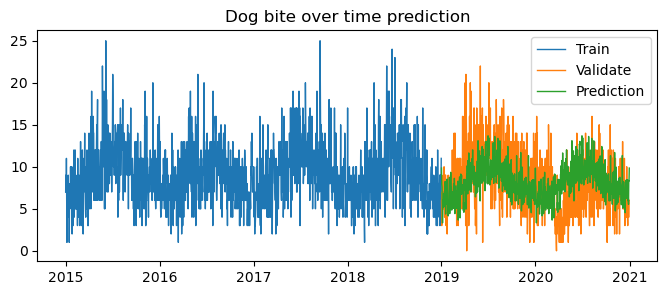

In [21]:
# add results to the evaluation dataframe
plot_evaluate(target= "bite")
eval_df = append_to_eval(model = 'holts_seasonal_trend', target = "bite")
eval_df.tail(3)

# Predict base on previous cycle

In [22]:
# Calculates the difference of a DataFrame element compared with another element
# period (lag) (must be th lenght of the validation season)
mean_diff = train.diff(periods=365 * 2).mean()
mean_diff

bite    0.21067
dtype: float64

In [23]:
# find the diff. add to each value in 2015.
y_pred_df = train['2016':'2017'] + mean_diff

# set yhat_df to index of validate
y_pred_df.index = validate.index

In [24]:
validate.head()

,bite
dateofbite,
2019-01-01,6
2019-01-02,3
2019-01-03,7
2019-01-04,4
2019-01-05,5


**Add to evaluation dataframe**

bite -- rmse: 5.16


,model,target,rmse
0,holts_optimized,bite,4.117
0,holts_seasonal_trend,bite,3.986
0,previous year,bite,5.159


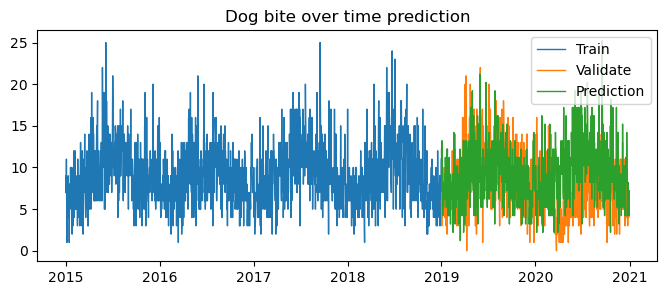

In [25]:
# add results to the evaluation dataframe
plot_evaluate(target= "bite")
eval_df = append_to_eval(model = 'previous year', target = "bite")
eval_df.tail(3)

## Best model

In [26]:
# reset the index
eval_df = eval_df.reset_index(drop=True)

In [27]:
# find best model
eval_df = eval_df.sort_values(by='rmse').head(5)
eval_df.head()

,model,target,rmse
135,136_day_moving_avg,bite,3.752
136,137_day_moving_avg,bite,3.753
134,135_day_moving_avg,bite,3.753
141,142_day_moving_avg,bite,3.753
137,138_day_moving_avg,bite,3.754


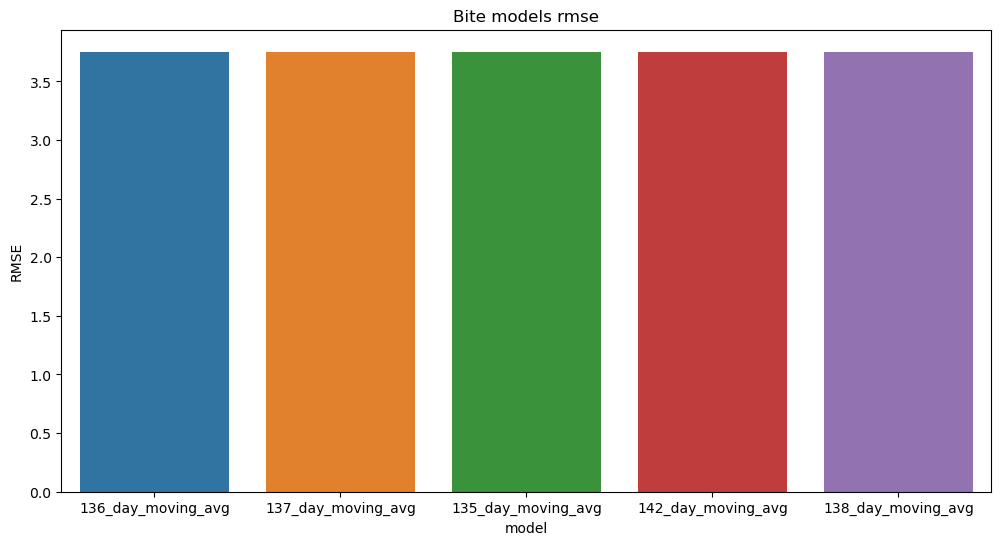

In [28]:

plt.figure(figsize=(12, 6))
sns.barplot(data= eval_df, x="model", y="rmse")
plt.title("Bite models rmse")
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()

## Test